In [3]:
pip install torch torchvision numpy matplotlib scipy

  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached fsspec-2024.10.0-py3-none-any.whl.metadata (11 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.0-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/203.0 MB ? eta -:--:--
   ---------------------------------------- 2.4/203.0 MB 12.2 MB/s eta 0:00:17
    --------------------------------------- 4.7/203.0 MB 11.9 MB/s eta 0:00:17
   - -------------------------------------- 7.1/203.0 MB 11.5 MB/s eta 0:00:18
   - -------------------------------------- 9.4/203.0 MB 11.5 MB/s eta 0:00:17
   -- ------------------------------------- 12.8/203.0 MB 12.2 MB/s eta 0:00:16
   --- ------------------------------------ 15.5/203.0 MB 11.9 MB/s eta 0:00:16
   

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from PIL import Image

# Set device and create output directory
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create output directory for generated images
os.makedirs("generated_images", exist_ok=True)

# Hyperparameters
lr = 0.0002
batch_size = 64
image_size = 64
channels_img = 3  # RGB images
z_dim = 100
num_epochs = 10
features_gen = 64
features_disc = 64

# Dataset class for loading Yelp images
class YelpDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_files = []
        
        # Filter out invalid images during initialization
        for f in os.listdir(image_folder):
            if f.endswith(('.jpg', '.jpeg', '.png')):
                try:
                    img_path = os.path.join(image_folder, f)
                    with Image.open(img_path) as img:
                        img.verify()  # Verify image integrity
                    self.image_files.append(f)
                except Exception as e:
                    print(f"Skipping corrupted image {f}: {str(e)}")
        
        print(f"Found {len(self.image_files)} valid images")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Keep trying until a valid image is loaded
        while True:
            try:
                img_path = os.path.join(self.image_folder, self.image_files[idx])
                image = Image.open(img_path).convert('RGB')
                if self.transform:
                    image = self.transform(image)
                return image
            except Exception as e:
                print(f"Error loading image {self.image_files[idx]}: {str(e)}")
                idx = (idx + 1) % len(self.image_files)  # Move to the next image

# Transformations for preprocessing the images
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5 for _ in range(channels_img)], [0.5 for _ in range(channels_img)]),
])

# Load the dataset
dataset = YelpDataset(image_folder='./a2_photos', transform=transform)

# Create data loader
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Using device: cpu
Found 1095 valid images


In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from PIL import Image

# Set device and create output directory
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create output directory for generated images
os.makedirs("generated_images", exist_ok=True)

# Hyperparameters
lr = 0.0002
batch_size = 64
image_size = 64
channels_img = 3  # RGB images
z_dim = 100
num_epochs = 10
features_gen = 64
features_disc = 64

# Dataset class for loading Yelp images
class YelpDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_files = []
        
        # Filter out invalid images during initialization
        for f in os.listdir(image_folder):
            if f.endswith(('.jpg', '.jpeg', '.png')):
                try:
                    img_path = os.path.join(image_folder, f)
                    with Image.open(img_path) as img:
                        img.verify()  # Verify image integrity
                    self.image_files.append(f)
                except Exception as e:
                    print(f"Skipping corrupted image {f}: {str(e)}")
        
        print(f"Found {len(self.image_files)} valid images")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Keep trying until a valid image is loaded
        while True:
            try:
                img_path = os.path.join(self.image_folder, self.image_files[idx])
                image = Image.open(img_path).convert('RGB')
                if self.transform:
                    image = self.transform(image)
                return image
            except Exception as e:
                print(f"Error loading image {self.image_files[idx]}: {str(e)}")
                idx = (idx + 1) % len(self.image_files)  # Move to the next image

# Transformations for preprocessing the images
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5 for _ in range(channels_img)], [0.5 for _ in range(channels_img)]),
])

# Load the dataset
dataset = YelpDataset(image_folder='./a2_photos', transform=transform)

# Create data loader
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Using device: cpu
Found 1095 valid images


In [5]:
len(dataset)

1095

In [6]:
import torch
import torch.nn as nn

# Generator class definition
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        
        # Define the layers of the generator using a sequential block
        self.gen = nn.Sequential(
            self._block(z_dim, features_g * 16, 4, 1, 0),  # 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # 32x32
            nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1),  # 64x64
            nn.Tanh(),  # Output layer activation (scaled to [-1, 1])
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        # Helper function to create the block
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),  # Use ReLU for activation
        )

    def forward(self, x):
        return self.gen(x)


In [ ]:
# Discriminator class definition
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()

        # Define the layers of the discriminator using a sequential block
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.LeakyReLU(0.2),  # Use LeakyReLU activation for better gradient flow
            self._block(features_d, features_d * 2, 4, 2, 1),  # 16x16
            self._block(features_d * 2, features_d * 4, 4, 2, 1),  # 8x8
            self._block(features_d * 4, features_d * 8, 4, 2, 1),  # 4x4
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),  # 1x1
            nn.Sigmoid(),  # Output layer with Sigmoid activation to output probabilities
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        # Helper function to create a block of layers for the discriminator
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),  # LeakyReLU with negative slope of 0.2
        )

    def forward(self, x):
        # Pass input through the discriminator
        return self.disc(x)


In [8]:
generator = Generator(z_dim, channels_img, features_gen).to(device)
discriminator = Discriminator(channels_img, features_disc).to(device)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image

# Optimizers for the generator and discriminator
optimizer_g = optim.RMSprop(generator.parameters(), lr=lr)
optimizer_d = optim.RMSprop(discriminator.parameters(), lr=lr)

# Training loop
num_epochs = 10
n_critic = 5  # Number of training steps for the discriminator

for epoch in range(num_epochs):
    for i, real_images in enumerate(loader):
        real_images = real_images.to(device)

        # Train the discriminator
        for _ in range(n_critic):
            optimizer_d.zero_grad()

            # Real images
            real_labels = torch.ones(real_images.size(0), 1).to(device)
            real_output = discriminator(real_images)
            d_loss_real = torch.mean(real_output)

            # Fake images
            noise = torch.randn(real_images.size(0), z_dim, 1, 1).to(device)
            fake_images = generator(noise)
            fake_labels = torch.zeros(real_images.size(0), 1).to(device)
            fake_output = discriminator(fake_images.detach())
            d_loss_fake = torch.mean(fake_output)

            # Total loss
            d_loss = d_loss_fake - d_loss_real
            d_loss.backward()

            # Weight clipping
            for p in discriminator.parameters():
                p.data.clamp_(-0.01, 0.01)

            optimizer_d.step()

        # Train the generator
        optimizer_g.zero_grad()

        noise = torch.randn(real_images.size(0), z_dim, 1, 1).to(device)
        fake_images = generator(noise)
        g_loss = -torch.mean(discriminator(fake_images))

        g_loss.backward()
        optimizer_g.step()

    # Save generated images
    if epoch % 1 == 0:
        generated_images = generator(noise).detach().cpu()
        save_image(generated_images, f"generated_images/generated_epoch_{epoch}.png", nrow=16, normalize=True)

    print(f"Epoch [{epoch}/{num_epochs}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

Epoch [0/10], D Loss: -0.3399268090724945, G Loss: -0.3295610249042511
Epoch [1/10], D Loss: -0.3623546361923218, G Loss: -0.3168748915195465
Epoch [2/10], D Loss: -0.34620487689971924, G Loss: -0.324056476354599
Epoch [3/10], D Loss: -0.30478063225746155, G Loss: -0.35205215215682983
Epoch [4/10], D Loss: -0.3613922894001007, G Loss: -0.32080984115600586
Epoch [5/10], D Loss: -0.36740782856941223, G Loss: -0.312892884016037
Epoch [6/10], D Loss: -0.2212468385696411, G Loss: -0.3260495066642761
Epoch [7/10], D Loss: -0.36610183119773865, G Loss: -0.31417518854141235
Epoch [8/10], D Loss: -0.3746528625488281, G Loss: -0.3129366934299469
Epoch [9/10], D Loss: -0.27154067158699036, G Loss: -0.4166967272758484


# TO DELETE

In [ ]:
# Assuming the DataLoader is set up with num_workers
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Training loop
num_epochs = 10
n_critic = 5  # Number of training steps for the discriminator

for epoch in range(num_epochs):
    for i, real_images in enumerate(loader):
        real_images = real_images.to(device)

        # Train the discriminator
        for _ in range(n_critic):
            optimizer_d.zero_grad()

            # Real images
            real_output = discriminator(real_images)
            d_loss_real = torch.mean(real_output)

            # Fake images
            noise = torch.randn(real_images.size(0), z_dim, 1, 1).to(device)
            fake_images = generator(noise)
            fake_output = discriminator(fake_images.detach())
            d_loss_fake = torch.mean(fake_output)

            # Total loss
            d_loss = d_loss_fake - d_loss_real
            d_loss.backward()

            # Weight clipping
            for p in discriminator.parameters():
                p.data.clamp_(-0.01, 0.01)

            optimizer_d.step()

        # Train the generator
        optimizer_g.zero_grad()

        noise = torch.randn(real_images.size(0), z_dim, 1, 1).to(device)
        fake_images = generator(noise)
        g_loss = -torch.mean(discriminator(fake_images))

        g_loss.backward()
        optimizer_g.step()

    # Save generated images periodically
    if epoch % 1 == 0:
        generated_images = generator(noise).detach().cpu()
        save_image(generated_images, f"generated_images/generated_epoch_{epoch}.png", nrow=16, normalize=True)

    print(f"Epoch [{epoch}/{num_epochs}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

In [ ]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

def show_all_generated_images(fake):
    grid = vutils.make_grid(fake, nrow=int(fake.shape[0] ** 0.5), padding=2, normalize=True)
    vutils.save_image(grid, 'generated_images.png')
    grid = grid.permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(8, 8))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()


Matplotlib is building the font cache; this may take a moment.


In [ ]:
import torch
from torchvision.utils import save_image

print("Generating images...")
generator.eval()  

with torch.no_grad():  
    for i in range(5): 
        noise = torch.randn(16, z_dim, 1, 1).to(device)
        fake = generator(noise)
        save_image(fake, f"generated_images/final_generated_set_{i+1}.png", normalize=True, nrow=4)

print("Image generation completed!")


Generating images...
Image generation completed!


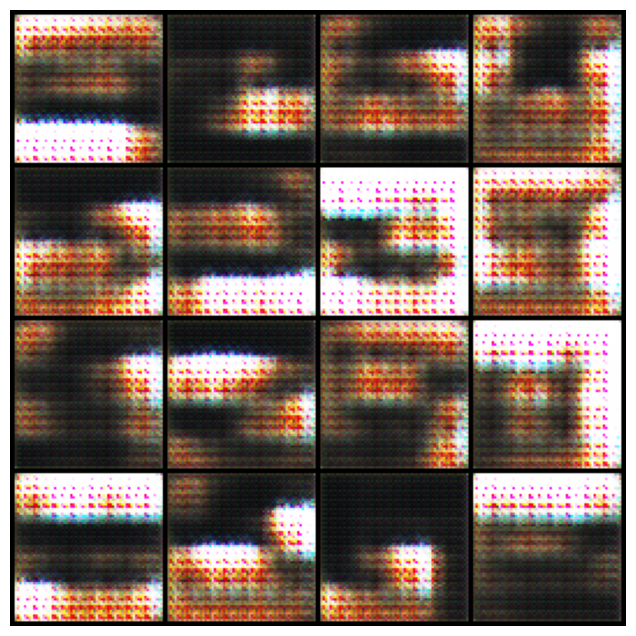

In [17]:
show_all_generated_images(fake)

### Trying to setup GPU for training

In [10]:
! pip show tensorflow

Name: tensorflow
Version: 2.12.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\user\appdata\local\programs\python\python39\lib\site-packages
Requires: tensorflow-intel
Required-by: 


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.cuda.is_available()

Using device: cpu


False

In [1]:
import tensorflow as tf
print("GPUs available:", tf.config.list_physical_devices('GPU'))

GPUs available: []


In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

### Setting up GPU not working. Reverting to CPU based executions

## WGAN-GP Implementation
Below is the implementation of WGAN-GP (Wasserstein GAN with Gradient Penalty) to improve stability and generated image quality.

In [ ]:
import torch.nn.functional as F

class DiscriminatorWGANGP(nn.Module):
    def __init__(self, channels_img, features_d):
        super(DiscriminatorWGANGP, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

# Gradient Penalty calculation for WGAN-GP
def gradient_penalty(critic, real, fake, device="cpu"):
    batch_size, c, h, w = real.shape
    alpha = torch.randn((batch_size, 1, 1, 1)).repeat(1, c, h, w).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take gradients of scores with respect to images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    penalty = torch.mean((gradient_norm - 1) ** 2)
    return penalty


## Visualizing Generated Images
This section includes visualization code to monitor training progress by displaying generated images at regular intervals.

In [ ]:
import matplotlib.pyplot as plt

def visualize_generated_images(generator, z_dim, num_images=25, img_size=(64, 64)):
    z = torch.randn(num_images, z_dim, 1, 1).to(device)
    generator.eval()
    with torch.no_grad():
        fake_images = generator(z).cpu()
    generator.train()
    
    fake_images = (fake_images + 1) / 2  # Rescale from [-1, 1] to [0, 1]
    grid_size = int(num_images ** 0.5)
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(fake_images[i].permute(1, 2, 0).squeeze(), cmap="gray")
        ax.axis("off")
    plt.show()


## Updated Training Loop
This section used the udpated WGAN setup to check for improvements in training & img generation

In [22]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.data[index]
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.data)


In [ ]:
for i, real_imgs in enumerate(dataloader):
    real_imgs = real_imgs.to(device)


In [29]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.0, 0.9))
optimizer_C = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.0, 0.9))

In [ ]:
import os

os.makedirs("models", exist_ok=True)
num_epochs = 10

for epoch in range(num_epochs):
    for i, real_imgs in enumerate(dataloader):
        real_imgs = real_imgs.to(device)

        # Train Critic
        for _ in range(n_critic):
            z = torch.randn(real_imgs.size(0), z_dim, 1, 1).to(device)
            fake_imgs = generator(z)
            
            real_validity = discriminator(real_imgs)
            fake_validity = discriminator(fake_imgs.detach())
            
            gp = gradient_penalty(discriminator, real_imgs, fake_imgs, device=device)
            critic_loss = -(torch.mean(real_validity) - torch.mean(fake_validity)) + lambda_gp * gp
            
            optimizer_C.zero_grad()
            critic_loss.backward()
            optimizer_C.step()

        # Train Generator
        z = torch.randn(real_imgs.size(0), z_dim, 1, 1).to(device)
        fake_imgs = generator(z)
        fake_validity = discriminator(fake_imgs)
        generator_loss = -torch.mean(fake_validity)
        
        optimizer_G.zero_grad()
        generator_loss.backward()
        optimizer_G.step()

Model not saved - SADLY! Rerun the training again...

In [43]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # Input: N x z_dim x 1 x 1
            self._block(z_dim, features_g * 16, 4, 1, 0),  # N x (features_g*16) x 4 x 4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # N x (features_g*8) x 8 x 8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # N x (features_g*4) x 16 x 16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # N x (features_g*2) x 32 x 32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),  # N x channels_img x 64 x 64
            nn.Tanh(),  # Output pixel values in range [-1, 1]
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.gen(x)


In [ ]:
z_dim = 100  # Latent space size
channels_img = 3  # Number of image channels (3 for RGB)
features_g = 64  # Feature size for the generator

generator = Generator(z_dim, channels_img, features_g).to(device)

In [46]:
import os

# Create a directory to store models (optional, for organization)
os.makedirs("models", exist_ok=True)

# Training Loop
num_epochs = 10

for epoch in range(num_epochs):
    for i, real_imgs in enumerate(dataloader):
        real_imgs = real_imgs.to(device)

        # Train Critic
        for _ in range(n_critic):
            z = torch.randn(real_imgs.size(0), z_dim, 1, 1).to(device)
            fake_imgs = generator(z)
            
            real_validity = discriminator(real_imgs)
            fake_validity = discriminator(fake_imgs.detach())
            
            gp = gradient_penalty(discriminator, real_imgs, fake_imgs, device=device)
            critic_loss = -(torch.mean(real_validity) - torch.mean(fake_validity)) + lambda_gp * gp
            
            optimizer_C.zero_grad()
            critic_loss.backward()
            optimizer_C.step()

        # Train Generator
        z = torch.randn(real_imgs.size(0), z_dim, 1, 1).to(device)
        fake_imgs = generator(z)
        fake_validity = discriminator(fake_imgs)
        generator_loss = -torch.mean(fake_validity)
        
        optimizer_G.zero_grad()
        generator_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{num_epochs}]  Critic Loss: {critic_loss.item():.4f}  Generator Loss: {generator_loss.item():.4f}")

    # Save models periodically, e.g., every 5 epochs
    if (epoch + 1) % 5 == 0:
        torch.save(generator.state_dict(), f"models/generator_epoch_{epoch+1}.pth")
        torch.save(discriminator.state_dict(), f"models/discriminator_epoch_{epoch+1}.pth")

# Save final models after training
torch.save(generator.state_dict(), "models/generator_final.pth")
torch.save(discriminator.state_dict(), "models/discriminator_final.pth")


Epoch [1/10]  Critic Loss: 7.0918  Generator Loss: -0.0000
Epoch [2/10]  Critic Loss: 2.7597  Generator Loss: -0.0005
Epoch [3/10]  Critic Loss: 2.1390  Generator Loss: -0.0000
Epoch [4/10]  Critic Loss: 1.9530  Generator Loss: -0.2071
Epoch [5/10]  Critic Loss: 5.1926  Generator Loss: -0.0008
Epoch [6/10]  Critic Loss: 4.0576  Generator Loss: -0.0090
Epoch [7/10]  Critic Loss: 8.5367  Generator Loss: -0.0004
Epoch [8/10]  Critic Loss: 4.2923  Generator Loss: -0.0001
Epoch [9/10]  Critic Loss: 1.5187  Generator Loss: -0.0000
Epoch [10/10]  Critic Loss: 6.8633  Generator Loss: -0.0000


In [47]:
generator.load_state_dict(torch.load("models/generator_final.pth"))
generator.eval()  # Set to evaluation mode


C:\Users\user\AppData\Local\Temp\ipykernel_13436\1730632434.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("models/generator_final.

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inpla

In [48]:
import torch
from torchvision.utils import save_image

print("Generating images...")
generator.eval()  

with torch.no_grad():  
    for i in range(5): 
        noise = torch.randn(16, z_dim, 1, 1).to(device)
        fake = generator(noise)
        save_image(fake, f"generated_images/final_generated_set_{i+1}.png", normalize=True, nrow=4)

print("Image generation completed!")


Generating images...
Image generation completed!


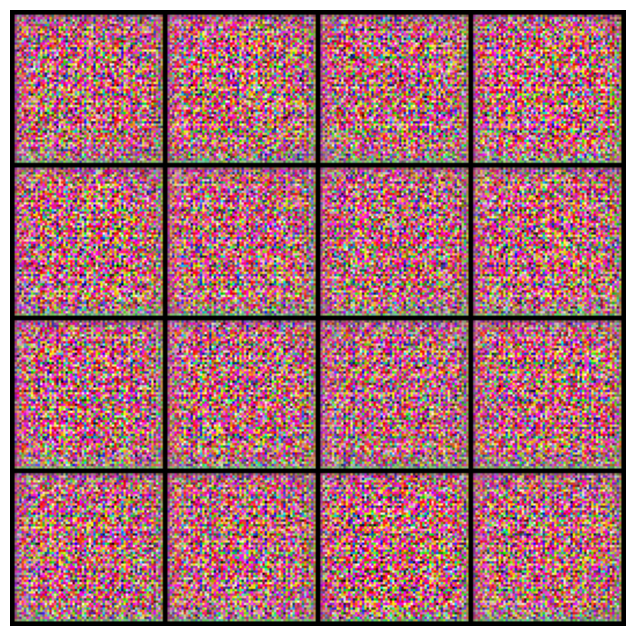

In [49]:
show_all_generated_images(fake)